In [1]:
# Enable autoreloading of modules
%load_ext autoreload
%autoreload 2

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Standard imports
import os
import sys
import random

# Data manipulation and analysis
import numpy as np
import pandas as pd

# Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt




# Custom utilities
sys.path.append('../')
from src.utils import load_config, split_into_sentences, flatten_list, load_and_clean_data
from src import stats_analysis as sa
from src.data_cleaning import add_average_data
from src.ml_utils import train_and_evaluate_rf, train_and_evaluate_xgb, filter_dataset



[nltk_data] Downloading package punkt to /home/robin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
config = load_config('../config.yaml')
data = load_and_clean_data(config)
data = add_average_data(data)
print(data.temperature_enc.value_counts())
print(data.has_paraphrase.value_counts())

Data contains at the begining : 18039
Filtering data with more than 20 sentences and less than 5 sentences. 18039 samples left
Filtering data with phone numbers. 18039 samples left
Filtering data with addresses. 18039 samples left
Filtering data with mail addresses. 18039 samples left
Filtering data with list. 18039 samples left
Filtering data with short paraphrase. 18039 samples left
Filtering data with paraphrase at the end. 18039 samples left
temperature_enc
medium_temperature    6416
low_temperature       6191
high_temperature      5432
Name: count, dtype: int64
has_paraphrase
0    9375
1    8664
Name: count, dtype: int64


In [ ]:
dataset = data[data.temperature_enc.isin(["low_temperature","medium_temperature"])]

In [4]:
import nltk
import re
nltk.download("punkt")

def fix_sentence_spacing(text: str) -> str:
    """
    Ensure there is a space after punctuation like '.', '!', '?'
    """
    # Add a space after '.', '!', '?' if not followed by space
    text = re.sub(r'([.!?])([^\s])', r'\1 \2', text)
    return text

def clean_sentences_nltk(text: str) -> str:
    """
    Fix punctuation spacing and tokenize sentences with NLTK.
    """
    text = fix_sentence_spacing(text)
    sentences = nltk.sent_tokenize(text)
    return " ".join(sentences)
# Apply to dataframe
dataset["altered_text_clean"] = dataset["altered_text"].apply(clean_sentences_nltk)

[nltk_data] Downloading package punkt to /home/robin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
import pandas as pd
import subprocess
import tempfile
import os
import time
from tqdm import tqdm

import os
import shlex
import time
import glob
import tempfile
import subprocess
import pandas as pd
from tqdm import tqdm

def run_neosca_batch_per_textfile(
    data: pd.DataFrame,
    text_column: str = "altered_text_clean",
    batch_size: int = 100,
    output_dir: str = "neosca_batches",
    java_mem: str = "8g",          # increase if needed (e.g., "8g")
    newline_break: str = "always", # "never" | "always" | "two"
    strict: bool = True,           # if True, raise on length mismatch
) -> pd.DataFrame:
    """
    Run NeoSCA in batches with ONE FILE PER TEXT so the output is 1 row per text.

    - Resumable: each batch writes a CSV in `output_dir`, and re-runs skip finished batches.
    - Fast: single JVM init per batch.
    - Safe: strict alignment (1 row per input file), with optional strict mode.

    Returns
    -------
    pd.DataFrame with all NeoSCA features, aligned 1:1 with input df rows.
    """

    os.makedirs(output_dir, exist_ok=True)
    df = data.copy()
    df = df.reset_index(drop=True).copy()
    n = len(df)

    # For ETA
    times = []
    total_batches = (n + batch_size - 1) // batch_size

    # Prepare base env (more Java heap)
    env = os.environ.copy()
    if java_mem:
        env["NSCA_JAVA_OPTS"] = f"-Xmx{java_mem}"

    all_parts = []

    for start in tqdm(range(0, n, batch_size), desc="Processing batches"):
        end = min(start + batch_size, n)
        batch_idx = start // batch_size
        out_csv = os.path.join(output_dir, f"neosca_batch_{batch_idx}.csv")

        # Skip if already done
        if os.path.exists(out_csv):
            # Read and keep
            try:
                part = pd.read_csv(out_csv)
                if strict and len(part) != (end - start):
                    raise ValueError(
                        f"[Strict] Saved batch {batch_idx} rows ({len(part)}) "
                        f"!= number of texts ({end - start})."
                    )
                all_parts.append(part)
                continue
            except Exception:
                # if corrupt, we’ll recompute
                pass

        t0 = time.time()

        # Create a temp dir with one file per text
        tmp_dir = tempfile.mkdtemp(prefix=f"neosca_batch_{batch_idx}_")
        file_paths = []
        for i, text in enumerate(df[text_column].iloc[start:end].astype(str), 1):
            # each text -> file
            p = os.path.join(tmp_dir, f"doc_{i:05d}.txt")
            # You can also ensure spacing cleanup here if needed
            with open(p, "w", encoding="utf-8") as f:
                f.write(text.strip() + "\n")
            file_paths.append(p)

        # Build command: nsca <file1> <file2> ...  --output-file out.csv ...
        file_args = " ".join(shlex.quote(p) for p in file_paths)
        cmd = f"nsca {file_args} --output-file {shlex.quote(out_csv)} --output-format csv"
        if newline_break:
            cmd += f" --newline-break {newline_break}"

        try:
            subprocess.run(cmd, shell=True, check=True, capture_output=True, env=env)

            # Read the batch output
            part = pd.read_csv(out_csv)

            # STRICT alignment: NeoSCA should output one row per input file in order
            if strict and len(part) != (end - start):
                raise ValueError(
                    f"[Strict] NeoSCA returned {len(part)} rows but batch has {end - start} texts."
                )

            # Attach original text column for convenience
            part.insert(0, text_column, df[text_column].iloc[start:end].values[:len(part)])

            # Overwrite the batch CSV including the text column (handy for resume)
            part.to_csv(out_csv, index=False)
            all_parts.append(part)

        except subprocess.CalledProcessError as e:
            # If NeoSCA fails for this batch, print stderr for debugging
            print(f"❌ NeoSCA error (batch {batch_idx+1}/{total_batches}):\n{e.stderr.decode('utf-8', 'ignore')}")
            # Optional: remove partial CSV to force re-run later
            if os.path.exists(out_csv):
                os.remove(out_csv)
            # Re-raise if you want hard fail; else continue to next batch
            raise
        finally:
            # Clean temp files
            for p in glob.glob(os.path.join(tmp_dir, "*.txt")):
                try: os.remove(p)
                except Exception: pass
            try: os.rmdir(tmp_dir)
            except Exception: pass

        # ETA
        elapsed = time.time() - t0
        times.append(elapsed)
        avg = sum(times) / len(times)
        remaining = total_batches - (batch_idx + 1)
        eta_min = (remaining * avg) / 60
        print(f"✅ batch {batch_idx+1}/{total_batches} in {elapsed:.1f}s | ETA ~ {eta_min:.1f} min")

    # Merge all parts (keeps the order by construction)
    if not all_parts:
        return pd.DataFrame()

    result = pd.concat(all_parts, ignore_index=True)

    # Final strict safety check: one row per input text
    if strict and len(result) != n:
        raise ValueError(
            f"[Strict] Final rows ({len(result)}) != input texts ({n}). "
            f"Check if some batches failed or if parser dropped rows."
        )

    # Align exactly 1:1 with input df by position
    result = result.iloc[:n].reset_index(drop=True)
    result[text_column] = df[text_column].values[:len(result)]

    return result


In [6]:
results = run_neosca_batch_per_textfile(dataset, text_column="altered_text_clean", batch_size=150, output_dir="neosca_batches")

Processing batches:   1%|          | 1/85 [02:27<3:26:31, 147.52s/it]

✅ batch 1/85 in 147.5s | ETA ~ 206.5 min


Processing batches:   2%|▏         | 2/85 [05:15<3:40:36, 159.47s/it]

✅ batch 2/85 in 167.8s | ETA ~ 218.1 min


Processing batches:   4%|▎         | 3/85 [08:49<4:12:02, 184.42s/it]

✅ batch 3/85 in 214.1s | ETA ~ 241.2 min


Processing batches:   5%|▍         | 4/85 [12:02<4:13:45, 187.97s/it]

✅ batch 4/85 in 193.4s | ETA ~ 244.0 min


Processing batches:   6%|▌         | 5/85 [14:39<3:55:43, 176.80s/it]

✅ batch 5/85 in 157.0s | ETA ~ 234.6 min


Processing batches:   7%|▋         | 6/85 [17:06<3:39:15, 166.52s/it]

✅ batch 6/85 in 146.6s | ETA ~ 225.2 min


Processing batches:   8%|▊         | 7/85 [19:41<3:31:28, 162.68s/it]

✅ batch 7/85 in 154.8s | ETA ~ 219.4 min


Processing batches:   9%|▉         | 8/85 [21:51<3:15:38, 152.45s/it]

✅ batch 8/85 in 130.6s | ETA ~ 210.4 min


Processing batches:  11%|█         | 9/85 [24:14<3:09:03, 149.26s/it]

✅ batch 9/85 in 142.2s | ETA ~ 204.6 min


Processing batches:  12%|█▏        | 10/85 [26:56<3:11:46, 153.42s/it]

✅ batch 10/85 in 162.7s | ETA ~ 202.1 min


Processing batches:  13%|█▎        | 11/85 [30:17<3:26:56, 167.79s/it]

✅ batch 11/85 in 200.4s | ETA ~ 203.7 min


Processing batches:  14%|█▍        | 12/85 [34:02<3:45:36, 185.43s/it]

✅ batch 12/85 in 225.8s | ETA ~ 207.1 min


Processing batches:  15%|█▌        | 13/85 [37:33<3:51:45, 193.13s/it]

✅ batch 13/85 in 210.8s | ETA ~ 208.0 min


Processing batches:  16%|█▋        | 14/85 [40:55<3:51:41, 195.79s/it]

✅ batch 14/85 in 202.0s | ETA ~ 207.6 min


Processing batches:  18%|█▊        | 15/85 [44:12<3:48:46, 196.10s/it]

✅ batch 15/85 in 196.8s | ETA ~ 206.3 min


Processing batches:  19%|█▉        | 16/85 [47:33<3:47:04, 197.46s/it]

✅ batch 16/85 in 200.6s | ETA ~ 205.1 min


Processing batches:  20%|██        | 17/85 [51:09<3:50:07, 203.06s/it]

✅ batch 17/85 in 216.1s | ETA ~ 204.6 min


Processing batches:  21%|██        | 18/85 [54:30<3:46:06, 202.48s/it]

✅ batch 18/85 in 201.1s | ETA ~ 202.9 min


Processing batches:  22%|██▏       | 19/85 [56:44<3:20:02, 181.86s/it]

✅ batch 19/85 in 133.8s | ETA ~ 197.1 min


Processing batches:  24%|██▎       | 20/85 [59:21<3:08:56, 174.41s/it]

✅ batch 20/85 in 157.1s | ETA ~ 192.9 min


Processing batches:  25%|██▍       | 21/85 [1:02:46<3:15:59, 183.74s/it]

✅ batch 21/85 in 205.5s | ETA ~ 191.3 min


Processing batches:  26%|██▌       | 22/85 [1:05:35<3:08:12, 179.24s/it]

✅ batch 22/85 in 168.8s | ETA ~ 187.8 min


Processing batches:  27%|██▋       | 23/85 [1:07:53<2:52:31, 166.97s/it]

✅ batch 23/85 in 138.3s | ETA ~ 183.0 min


Processing batches:  28%|██▊       | 24/85 [1:10:08<2:39:55, 157.31s/it]

✅ batch 24/85 in 134.8s | ETA ~ 178.3 min


Processing batches:  29%|██▉       | 25/85 [1:12:30<2:32:39, 152.65s/it]

✅ batch 25/85 in 141.8s | ETA ~ 174.0 min


Processing batches:  31%|███       | 26/85 [1:14:34<2:21:47, 144.20s/it]

✅ batch 26/85 in 124.5s | ETA ~ 169.2 min


Processing batches:  32%|███▏      | 27/85 [1:16:36<2:12:49, 137.41s/it]

✅ batch 27/85 in 121.6s | ETA ~ 164.6 min


Processing batches:  33%|███▎      | 28/85 [1:18:23<2:01:51, 128.26s/it]

✅ batch 28/85 in 106.9s | ETA ~ 159.6 min


Processing batches:  34%|███▍      | 29/85 [1:21:20<2:13:18, 142.82s/it]

✅ batch 29/85 in 176.8s | ETA ~ 157.1 min


Processing batches:  35%|███▌      | 30/85 [1:24:54<2:30:35, 164.27s/it]

✅ batch 30/85 in 214.3s | ETA ~ 155.7 min


Processing batches:  36%|███▋      | 31/85 [1:28:27<2:40:55, 178.81s/it]

✅ batch 31/85 in 212.7s | ETA ~ 154.1 min


Processing batches:  38%|███▊      | 32/85 [1:32:06<2:48:42, 190.99s/it]

✅ batch 32/85 in 219.4s | ETA ~ 152.6 min


Processing batches:  39%|███▉      | 33/85 [1:35:17<2:45:34, 191.04s/it]

✅ batch 33/85 in 191.2s | ETA ~ 150.2 min


Processing batches:  40%|████      | 34/85 [1:38:38<2:44:58, 194.08s/it]

✅ batch 34/85 in 201.2s | ETA ~ 148.0 min


Processing batches:  41%|████      | 35/85 [1:41:44<2:39:42, 191.65s/it]

✅ batch 35/85 in 186.0s | ETA ~ 145.4 min


Processing batches:  42%|████▏     | 36/85 [1:44:35<2:31:14, 185.20s/it]

✅ batch 36/85 in 170.1s | ETA ~ 142.3 min


Processing batches:  44%|████▎     | 37/85 [1:46:47<2:15:35, 169.48s/it]

✅ batch 37/85 in 132.8s | ETA ~ 138.5 min


Processing batches:  45%|████▍     | 38/85 [1:50:00<2:18:14, 176.48s/it]

✅ batch 38/85 in 192.8s | ETA ~ 136.1 min


Processing batches:  46%|████▌     | 39/85 [1:53:21<2:20:51, 183.74s/it]

✅ batch 39/85 in 200.7s | ETA ~ 133.7 min


Processing batches:  47%|████▋     | 40/85 [1:56:08<2:14:11, 178.92s/it]

✅ batch 40/85 in 167.7s | ETA ~ 130.7 min


Processing batches:  48%|████▊     | 41/85 [1:58:35<2:04:03, 169.18s/it]

✅ batch 41/85 in 146.5s | ETA ~ 127.3 min


Processing batches:  49%|████▉     | 42/85 [2:00:56<1:55:12, 160.76s/it]

✅ batch 42/85 in 141.1s | ETA ~ 123.8 min


Processing batches:  51%|█████     | 43/85 [2:03:36<1:52:22, 160.53s/it]

✅ batch 43/85 in 160.0s | ETA ~ 120.7 min


Processing batches:  52%|█████▏    | 44/85 [2:05:59<1:46:09, 155.34s/it]

✅ batch 44/85 in 143.2s | ETA ~ 117.4 min


Processing batches:  53%|█████▎    | 45/85 [2:08:32<1:43:06, 154.66s/it]

✅ batch 45/85 in 153.1s | ETA ~ 114.3 min


Processing batches:  54%|█████▍    | 46/85 [2:11:01<1:39:21, 152.85s/it]

✅ batch 46/85 in 148.6s | ETA ~ 111.1 min


Processing batches:  55%|█████▌    | 47/85 [2:13:21<1:34:17, 148.88s/it]

✅ batch 47/85 in 139.6s | ETA ~ 107.8 min


Processing batches:  56%|█████▋    | 48/85 [2:16:01<1:33:59, 152.41s/it]

✅ batch 48/85 in 160.7s | ETA ~ 104.9 min


Processing batches:  58%|█████▊    | 49/85 [2:18:22<1:29:18, 148.84s/it]

✅ batch 49/85 in 140.5s | ETA ~ 101.7 min


Processing batches:  59%|█████▉    | 50/85 [2:21:28<1:33:23, 160.10s/it]

✅ batch 50/85 in 186.4s | ETA ~ 99.0 min


Processing batches:  60%|██████    | 51/85 [2:24:44<1:36:47, 170.82s/it]

✅ batch 51/85 in 195.8s | ETA ~ 96.5 min


Processing batches:  61%|██████    | 52/85 [2:28:10<1:39:49, 181.50s/it]

✅ batch 52/85 in 206.4s | ETA ~ 94.0 min


Processing batches:  62%|██████▏   | 53/85 [2:31:37<1:40:49, 189.04s/it]

✅ batch 53/85 in 206.6s | ETA ~ 91.5 min


Processing batches:  64%|██████▎   | 54/85 [2:35:01<1:39:59, 193.53s/it]

✅ batch 54/85 in 204.0s | ETA ~ 89.0 min


Processing batches:  65%|██████▍   | 55/85 [2:38:26<1:38:32, 197.07s/it]

✅ batch 55/85 in 205.3s | ETA ~ 86.4 min


Processing batches:  66%|██████▌   | 56/85 [2:41:40<1:34:45, 196.07s/it]

✅ batch 56/85 in 193.7s | ETA ~ 83.7 min


Processing batches:  67%|██████▋   | 57/85 [2:44:55<1:31:20, 195.74s/it]

✅ batch 57/85 in 195.0s | ETA ~ 81.0 min


Processing batches:  68%|██████▊   | 58/85 [2:48:05<1:27:14, 193.87s/it]

✅ batch 58/85 in 189.5s | ETA ~ 78.2 min


Processing batches:  69%|██████▉   | 59/85 [2:51:37<1:26:25, 199.44s/it]

✅ batch 59/85 in 212.4s | ETA ~ 75.6 min


Processing batches:  71%|███████   | 60/85 [2:54:45<1:21:43, 196.15s/it]

✅ batch 60/85 in 188.5s | ETA ~ 72.8 min


Processing batches:  72%|███████▏  | 61/85 [2:57:08<1:12:00, 180.04s/it]

✅ batch 61/85 in 142.4s | ETA ~ 69.7 min


Processing batches:  73%|███████▎  | 62/85 [2:59:29<1:04:34, 168.44s/it]

✅ batch 62/85 in 141.4s | ETA ~ 66.6 min


Processing batches:  74%|███████▍  | 63/85 [3:02:56<1:05:59, 179.98s/it]

✅ batch 63/85 in 206.9s | ETA ~ 63.9 min


Processing batches:  75%|███████▌  | 64/85 [3:05:36<1:00:50, 173.83s/it]

✅ batch 64/85 in 159.5s | ETA ~ 60.9 min


Processing batches:  76%|███████▋  | 65/85 [3:07:53<54:15, 162.76s/it]  

✅ batch 65/85 in 136.9s | ETA ~ 57.8 min


Processing batches:  78%|███████▊  | 66/85 [3:10:10<49:10, 155.28s/it]

✅ batch 66/85 in 137.8s | ETA ~ 54.7 min


Processing batches:  79%|███████▉  | 67/85 [3:12:19<44:09, 147.19s/it]

✅ batch 67/85 in 128.3s | ETA ~ 51.7 min


Processing batches:  80%|████████  | 68/85 [3:14:36<40:52, 144.25s/it]

✅ batch 68/85 in 137.4s | ETA ~ 48.7 min


Processing batches:  81%|████████  | 69/85 [3:16:47<37:23, 140.22s/it]

✅ batch 69/85 in 130.8s | ETA ~ 45.6 min


Processing batches:  82%|████████▏ | 70/85 [3:18:59<34:25, 137.73s/it]

✅ batch 70/85 in 131.9s | ETA ~ 42.6 min


Processing batches:  84%|████████▎ | 71/85 [3:21:13<31:51, 136.57s/it]

✅ batch 71/85 in 133.9s | ETA ~ 39.7 min


Processing batches:  85%|████████▍ | 72/85 [3:23:22<29:06, 134.31s/it]

✅ batch 72/85 in 129.0s | ETA ~ 36.7 min


Processing batches:  86%|████████▌ | 73/85 [3:25:43<27:16, 136.34s/it]

✅ batch 73/85 in 141.1s | ETA ~ 33.8 min


Processing batches:  87%|████████▋ | 74/85 [3:28:19<26:03, 142.16s/it]

✅ batch 74/85 in 155.7s | ETA ~ 31.0 min


Processing batches:  88%|████████▊ | 75/85 [3:31:17<25:31, 153.13s/it]

✅ batch 75/85 in 178.7s | ETA ~ 28.2 min


Processing batches:  89%|████████▉ | 76/85 [3:34:29<24:42, 164.75s/it]

✅ batch 76/85 in 191.9s | ETA ~ 25.4 min


Processing batches:  91%|█████████ | 77/85 [3:37:36<22:51, 171.47s/it]

✅ batch 77/85 in 187.1s | ETA ~ 22.6 min


Processing batches:  92%|█████████▏| 78/85 [3:40:49<20:45, 177.89s/it]

✅ batch 78/85 in 192.9s | ETA ~ 19.8 min


Processing batches:  93%|█████████▎| 79/85 [3:43:56<18:02, 180.49s/it]

✅ batch 79/85 in 186.6s | ETA ~ 17.0 min


Processing batches:  94%|█████████▍| 80/85 [3:46:58<15:05, 181.11s/it]

✅ batch 80/85 in 182.5s | ETA ~ 14.2 min


Processing batches:  95%|█████████▌| 81/85 [3:50:06<12:12, 183.14s/it]

✅ batch 81/85 in 187.9s | ETA ~ 11.4 min


Processing batches:  96%|█████████▋| 82/85 [3:53:09<09:09, 183.04s/it]

✅ batch 82/85 in 182.8s | ETA ~ 8.5 min


Processing batches:  98%|█████████▊| 83/85 [3:56:10<06:04, 182.33s/it]

✅ batch 83/85 in 180.7s | ETA ~ 5.7 min


Processing batches:  99%|█████████▉| 84/85 [3:59:19<03:04, 184.47s/it]

✅ batch 84/85 in 189.5s | ETA ~ 2.8 min


Processing batches: 100%|██████████| 85/85 [3:59:29<00:00, 169.05s/it]

✅ batch 85/85 in 10.0s | ETA ~ 0.0 min


In [9]:
results.to_pickle("syntactic_complexity.pkl")

In [ ]:
import pandas as pd
import numpy as np
import itertools
import statsmodels.api as sm
from scipy import stats












In [ ]:
# =========
# 0) MERGE
# =========
def merge_semantic_and_syntax(
    df_features: pd.DataFrame,      # original table with PCA_unexplained_variance
    df_neosca: pd.DataFrame,        # NeoSCA per-text features
    on: str = "altered_text_clean",            # common key to merge on
    text_col_in_neosca: str = "altered_text_clean",  # just kept for reference
    keep_cols_from_neosca: list = None
) -> pd.DataFrame:
    """
    Merge your existing features with NeoSCA results.
    Assumes df_features and df_neosca share an ID column (e.g., 'text_id').
    If you don’t have an ID, create one in both tables before calling this.
    """
    if keep_cols_from_neosca is None:
        # keep everything except Filename path
        keep_cols_from_neosca = [c for c in df_neosca.columns if c != "Filename"]

    # Avoid duplicate columns on merge
    right = df_neosca[ [on] + [c for c in keep_cols_from_neosca if c != on] ].copy()
    out = df_features.merge(right, on=on, how="inner")
    return out


merge_df = merge_semantic_and_syntax(dataset,results)

In [ ]:
def _safe_ratio(num, den):
    num = num.astype(float)
    den = den.astype(float)
    out = num / den.replace({0: np.nan})
    return out.replace([np.inf, -np.inf], np.nan)

def add_derived_length_means(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add the classic Lu 'length' means derived from counts:
    MLS=W/S, MLT=W/T, MLC=W/C
    """
    df = df.copy()
    for col in ["W","S","T","C"]:
        if col not in df.columns:
            df[col] = np.nan
    df["MLS"] = _safe_ratio(df["W"], df["S"])  # Mean length of sentence
    df["MLT"] = _safe_ratio(df["W"], df["T"])  # Mean length of T-unit
    df["MLC"] = _safe_ratio(df["W"], df["C"])  # Mean length of clause
    return df

def zscore(s: pd.Series) -> pd.Series:
    return (s - s.mean(skipna=True)) / s.std(skipna=True)

def build_syntax_domains_from_available(df: pd.DataFrame) -> pd.DataFrame:
    """
    Build domain composites (z-averages) from indices you already have.
    We standardize each component and average within domain.

    Domains (proxies):
      - Length:      MLS, MLT, MLC
      - Global:      T/S     (T-units per sentence)
      - Clausal:     C/T, DC/C, DC/T    (+ optional C if desired)
      - Phrasal:     VP/T, CP/T, CP/C, CN/T, CN/C

    Length domain = “how long units are”

    Global domain = “complexity at sentence level”

    Clausal domain = “clause embedding and subordination”

    Phrasal domain = “phrasal elaboration”
    """
    df = add_derived_length_means(df)

    # Make sure missing columns exist (filled with NaN)
    needed = ["MLS","MLT","MLC","T/S","C/T","DC/C","DC/T","VP/T","CP/T","CP/C","CN/T","CN/C"]
    for c in needed:
        if c not in df.columns:
            df[c] = np.nan

    # Z-scores of components
    comps = {
        "Length":  ["MLS","MLT","MLC"],
        "Global":  ["T/S"],
        "Clausal": ["C/T","DC/C","DC/T"],
        "Phrasal": ["VP/T","CP/T","CP/C","CN/T","CN/C"],
    }

    for dom, cols in comps.items():
        zcols = []
        for c in cols:
            zc = f"z_{c}"
            df[zc] = zscore(df[c]) if df[c].notna().any() else np.nan
            zcols.append(zc)
        # domain composite = mean of available z’s
        df[f"{dom}"] = df[zcols].mean(axis=1)

    return df


merge_df = build_syntax_domains_from_available(merge_df)

In [22]:
# =========================================
# 1) SPEARMAN CORRELATIONS (robust to non-normality)
# =========================================
def spearman_with_p(values_df: pd.DataFrame, target:str, cols: list) -> pd.DataFrame:
    """
    Compute Spearman correlations and two-sided p-values between the first column and the rest.
    cols[0] is treated as the target (semantic score).
    """
    rows = []
    for c in cols:
        x = values_df[target]
        y = values_df[c]
        mask = x.notna() & y.notna()
        if mask.sum() < 3:
            r, p = np.nan, np.nan
        else:
            r, p = stats.spearmanr(x[mask], y[mask])
        rows.append({"feature": c, "spearman_r": r, "p_value": p, "n": int(mask.sum())})
    return pd.DataFrame(rows).sort_values("spearman_r", ascending=False)



cols =['W',  'S',  'VP',  'C', 'T',  'DC',  'CT',  'CP',  'CN',  'MLS',  'MLT',  'MLC',  'C/S',
       'VP/T',  'C/T', 'DC/C', 'DC/T',  'T/S', 'CT/T',  'CP/T','CP/C',  'CN/T', 'CN/C',
       "Length","Global","Clausal","Phrasal"]
spearman_with_p(merge_df,target="reduction_score_PCA_explained_variance",cols =cols)

,feature,spearman_r,p_value,n
1,S,0.655244,0.000000e+00,14755
4,T,0.537194,0.000000e+00,14755
3,C,0.294796,1.246216e-293,14755
2,VP,0.187821,3.092640e-117,14755
6,CT,0.069892,1.903864e-17,14755
5,DC,-0.024430,3.000082e-03,14755
0,W,-0.079887,2.512565e-22,14755
8,CN,-0.129960,1.358603e-56,14755
17,T/S,-0.213625,7.076267e-152,14755
24,Global,-0.213625,7.076267e-152,14755


In [31]:
# =========================================
# 2) HIERARCHICAL REGRESSION & RESIDUALIZATION
# =========================================
def regression_and_residuals(
    df: pd.DataFrame,
    y_col: str,                     # semantic score: e.g., "PCA_unexplained_variance"
    syntax_domain_cols: list,       # e.g., ["Length","Global","Clausal","Phrasal"]
    covariates: list = None         # optional: ["age","sex","group","W","S"] etc.
):
    """
    Fit OLS:  y ~ covariates + syntax_domains
    Returns model summary, R2, ΔR2 (added by syntactic domains), and residualized semantic score.
    """
    covariates = covariates or []
    df_ = df.copy()
    # Build design matrices
    X_base = df_[covariates].copy() if covariates else pd.DataFrame(index=df_.index)
    if len(X_base.columns) == 0:
        X_base = pd.DataFrame({"const": 1.0}, index=df_.index)
    else:
        X_base = sm.add_constant(X_base, has_constant="add")

    X_full = sm.add_constant(df_[covariates + syntax_domain_cols], has_constant="add")
    y = df_[y_col]

    # Base model
    m0 = sm.OLS(y, X_base, missing="drop").fit()
    r2_base = m0.rsquared

    # Full model
    m1 = sm.OLS(y, X_full, missing="drop").fit()
    r2_full = m1.rsquared
    delta_r2 = r2_full - r2_base

    # Residualized semantic score (semantic beyond syntax + covariates)
    y_hat = m1.fittedvalues.reindex(df_.index)
    df_["semantic_residual"] = y - y_hat

    # Nicely packed outputs
    added = pd.DataFrame({
        "term": ["syntax_block"],
        "R2_base": [r2_base],
        "R2_full": [r2_full],
        "delta_R2": [delta_r2]
    })
    # Coefs table
    coefs = m1.summary2().tables[1].reset_index().rename(columns={"index":"term"})
    return {
        "df_with_residual": df_,
        "base_model": m0,
        "full_model": m1,
        "added_variance_table": added,
        "coefficients_table": coefs
    }


semantic_col = "reduction_score_PCA_explained_variance"
syntax_domains = ["Length","Global","Clausal","Phrasal"]

reg = regression_and_residuals(merge_df, y_col=semantic_col,
                                   syntax_domain_cols=syntax_domains,
                                   )
df_with_resid = reg["df_with_residual"]
added_var = reg["added_variance_table"]
coefs_tbl = reg["coefficients_table"]

In [34]:
coefs_tbl


,term,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
0,const,0.476794,0.000509,936.935128,0.000000e+00,0.475797,0.477791
1,Length,-0.052479,0.001300,-40.368590,0.000000e+00,-0.055027,-0.049930
2,Global,-0.017385,0.000548,-31.738533,6.608489e-214,-0.018458,-0.016311
3,Clausal,-0.004278,0.000579,-7.387935,1.571183e-13,-0.005413,-0.003143
4,Phrasal,-0.006036,0.001548,-3.899753,9.671747e-05,-0.009070,-0.003002


In [33]:
added_var

,term,R2_base,R2_full,delta_R2
0,syntax_block,-2.220446e-16,0.425116,0.425116


In [35]:
# 3) COMMONALITY / SHAPLEY (variance partitioning)
# =========================================
def shapley_r2(df: pd.DataFrame, y_col: str, X_cols: list, covariates: list = None):
    """
    Shapley (a.k.a. LMG / relative importance): apportion R^2 across predictors.
    We compute the average marginal contribution of each predictor across all subsets.

    Returns:
      - contributions (pd.Series): unique contribution to R2 for each predictor
      - total_R2 (float)
    """
    covariates = covariates or []
    idx = df.dropna(subset=[y_col] + covariates + X_cols).index
    y = df.loc[idx, y_col]
    total_R2 = None

    def fit_r2(cols):
        X = sm.add_constant(df.loc[idx, covariates + cols], has_constant="add")
        return sm.OLS(y, X).fit().rsquared

    # all subsets for marginal contributions
    contrib = {x: 0.0 for x in X_cols}
    all_sets = list(itertools.chain.from_iterable(
        itertools.combinations(X_cols, k) for k in range(len(X_cols)+1)
    ))

    # For each predictor, average its marginal ΔR2 across all subset contexts
    for x in X_cols:
        num_contexts = 0
        delta_sum = 0.0
        for S in all_sets:
            S = list(S)
            if x in S:
                continue
            r2_S = fit_r2(S)
            r2_Sx = fit_r2(S + [x])
            delta_sum += (r2_Sx - r2_S)
            num_contexts += 1
        contrib[x] = delta_sum / num_contexts if num_contexts > 0 else 0.0

    # Total R2 of the full model (with all predictors + covariates)
    total_R2 = fit_r2(X_cols)
    return pd.Series(contrib).sort_values(ascending=False), total_R2

shapley_r2(merge_df, y_col = semantic_col, X_cols = syntax_domains)


(Length     0.215940
 Phrasal    0.126293
 Global     0.055283
 Clausal    0.021746
 dtype: float64,
 0.4251159574429305)

In [40]:
# =========================================
# 4) QUICK DRIVER: from merged DF to all outputs
# =========================================
def answer_reviewer_pipeline(
    df_merged: pd.DataFrame,
    semantic_col: str = "PCA_unexplained_variance",
    syntax_domains: list = ["Length","Global","Clausal","Phrasal"],
    covariates: list = None
):
    """
    Runs:
     - Spearman correlations between semantic_col and each syntax domain.
     - Hierarchical OLS: added variance from syntax beyond covariates.
     - Residualized semantic score (semantic beyond syntax).
     - Shapley/commonality analysis for unique vs shared variance.
    """
    # 1) Correlations
    corr_table = spearman_with_p(df_merged, target = semantic_col, cols = syntax_domains)

    # 2) Hierarchical regression & residuals
    reg = regression_and_residuals(df_merged, y_col=semantic_col,
                                   syntax_domain_cols=syntax_domains,
                                   covariates=covariates)
    df_with_resid = reg["df_with_residual"]
    added_var = reg["added_variance_table"]
    coefs_tbl = reg["coefficients_table"]

    # 3) Shapley/commonality
    shapley_contrib, total_R2 = shapley_r2(df_merged, y_col=semantic_col,
                                           X_cols=syntax_domains, covariates=covariates)
    shapley_table = shapley_contrib.reset_index()
    shapley_table.columns = ["predictor", "shapley_R2_contribution"]
    shapley_table["total_R2_full_model"] = total_R2

    return {
        "correlations": corr_table,
        "added_variance": added_var,
        "coefficients": coefs_tbl,
        #"residualized_df": df_with_resid,
        "shapley": shapley_table
    }

In [41]:
answer_reviewer_pipeline(df_merged=merge_df,semantic_col=semantic_col,syntax_domains=syntax_domains)

{'correlations':    feature  spearman_r        p_value      n
 1   Global   -0.213625  7.076267e-152  14755
 2  Clausal   -0.277745  1.546555e-259  14755
 3  Phrasal   -0.500609   0.000000e+00  14755
 0   Length   -0.613179   0.000000e+00  14755,
 'added_variance':            term       R2_base   R2_full  delta_R2
 0  syntax_block -2.220446e-16  0.425116  0.425116,
 'coefficients':       term     Coef.  Std.Err.           t          P>|t|    [0.025    0.975]
 0    const  0.476794  0.000509  936.935128   0.000000e+00  0.475797  0.477791
 1   Length -0.052479  0.001300  -40.368590   0.000000e+00 -0.055027 -0.049930
 2   Global -0.017385  0.000548  -31.738533  6.608489e-214 -0.018458 -0.016311
 3  Clausal -0.004278  0.000579   -7.387935   1.571183e-13 -0.005413 -0.003143
 4  Phrasal -0.006036  0.001548   -3.899753   9.671747e-05 -0.009070 -0.003002,
 'shapley':   predictor  shapley_R2_contribution  total_R2_full_model
 0    Length                 0.215940             0.425116
 1   Phrasal

In [44]:
syntactic_features = ['W',  'S',  'VP',  'C', 'T',  'DC',  'CT',  'CP',  'CN',  'MLS',  'MLT',  'MLC',  'C/S',
       'VP/T',  'C/T', 'DC/C', 'DC/T',  'T/S', 'CT/T',  'CP/T','CP/C',  'CN/T', 'CN/C',]

features_dict = {
        "syntactic_features": syntactic_features,
    }

best_parameters_dict = {
    "syntactic_features": {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 10, 'bootstrap': True},
}



label_encoded_dict = {
    'low_temperature_with_paraphrase': 0,
    'low_temperature_with_no_paraphrase': 1,
    "medium_temperature_with_paraphrase": 2,
    "medium_temperature_with_no_paraphrase": 3,
    #"high_temperature_with_paraphrase": 4,
    #"high_temperature_with_no_paraphrase": 5
}

num_to_label = {v: k for k, v in label_encoded_dict.items()}

ml_dataset = merge_df.sample(frac = 1).copy()
#dataset = dataset[~dataset[mean_sim_metrics].isin([-1]).any(axis=1)]



ml_dataset['cat_label'] = ml_dataset.combined_label.map(label_encoded_dict)#.apply(int)
ml_dataset['cat_label'].value_counts()

print(dataset.combined_label.value_counts())

combined_label
medium_temperature_with_no_paraphrase    3384
low_temperature_with_no_paraphrase       3262
medium_temperature_with_paraphrase       3032
low_temperature_with_paraphrase          2929
Name: count, dtype: int64


########################################
Training with syntactic_features
Accuracy: 0.3734090464068925
F1 Score: 0.32052127553143217


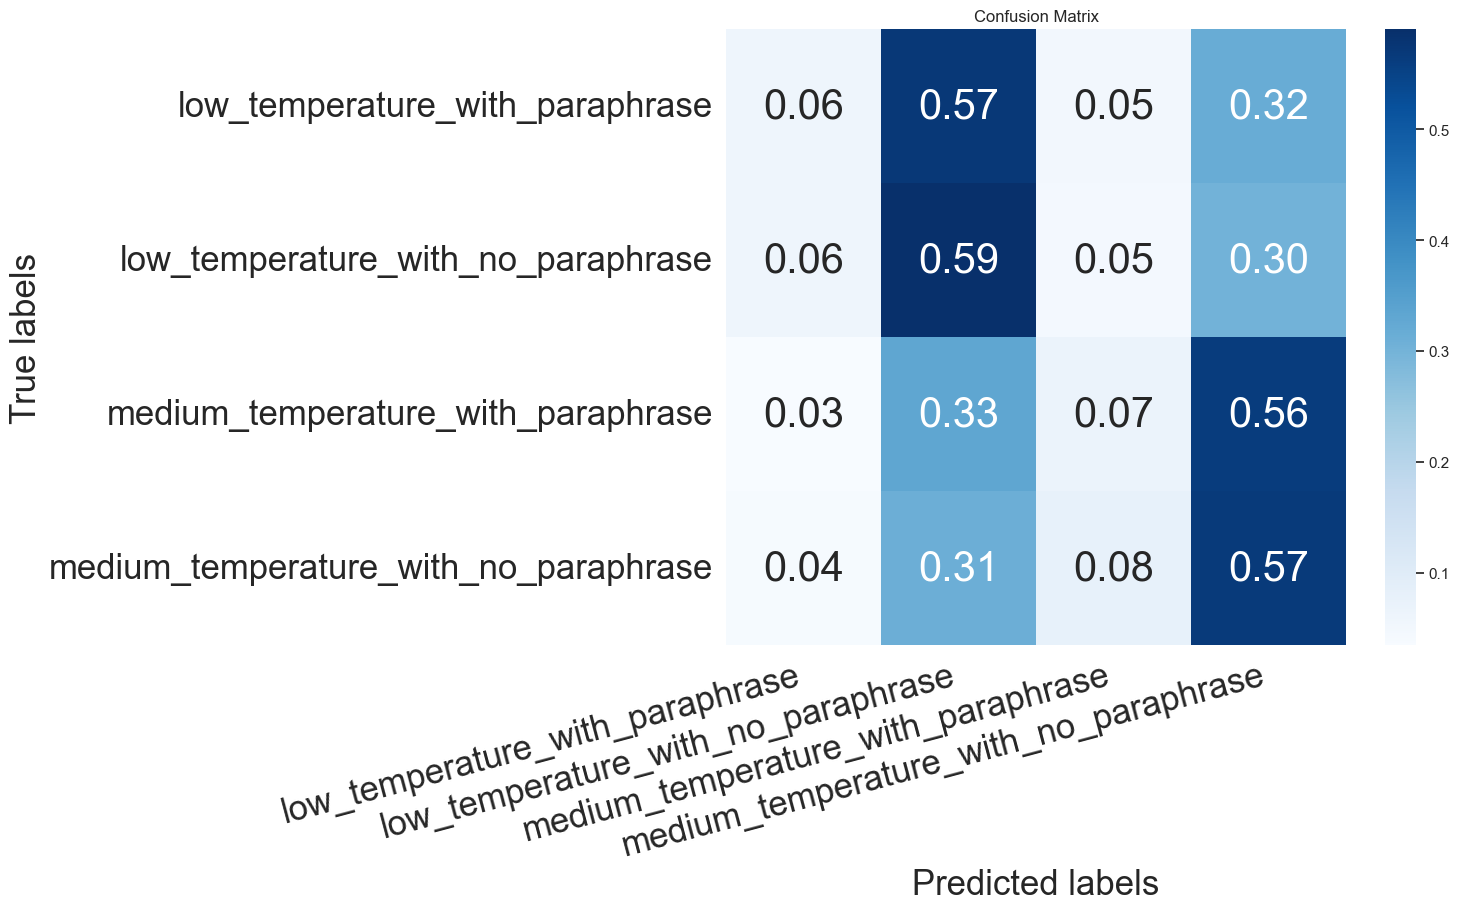

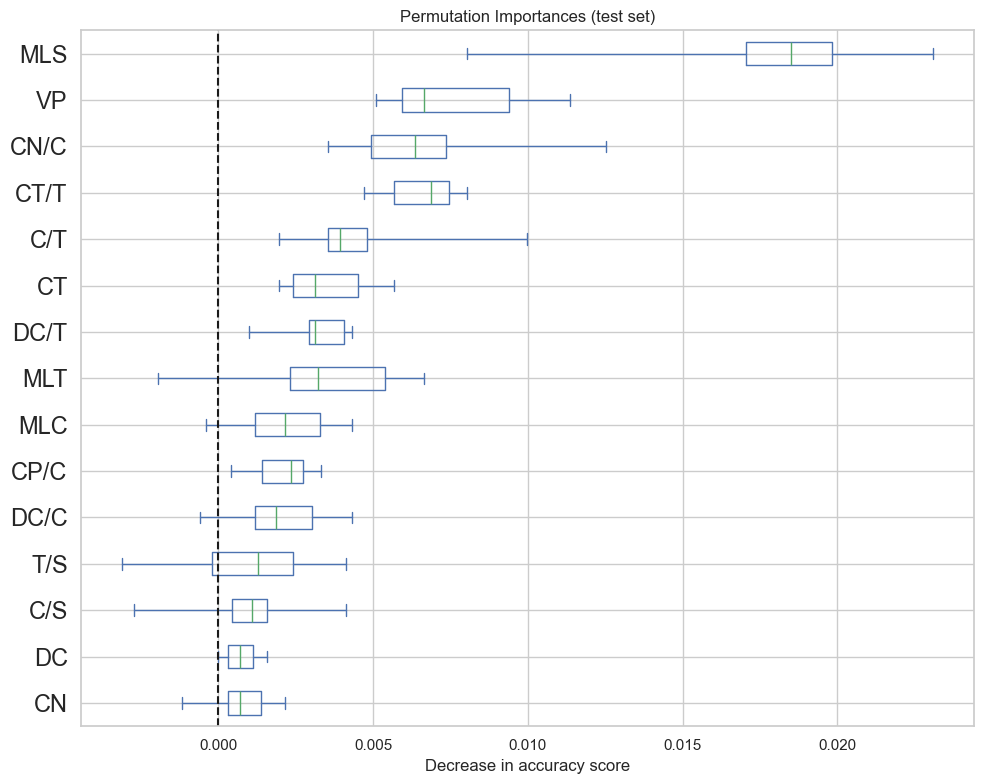

possible_misclassifications_paraphrase_only 5107
error_paraphrase_only 1373
possible_misclassifications_temperature_only 5107
error_temperature_only 1028
possible_misclassifications_fail_dissociate 2544
error_fail_dissociate 409


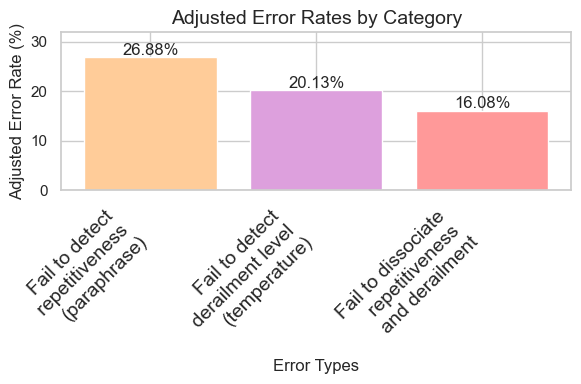

,features_name,accuracy,f1_score
0,syntactic_features,0.373409,0.320521


In [45]:
## ML analysis
from src.ml_utils import train_and_evaluate_rf


plot = True
compute_context_auc  = False
error_type =True
df_results = train_and_evaluate_rf(features_dict,best_parameters_dict, ml_dataset, y_name="cat_label", num_to_label = num_to_label, plot = plot, plot_error_type=error_type)
df_results.sort_values(by = "f1_score", ascending = False)
df_results[['features_name','accuracy','f1_score']].sort_values(by = "f1_score", ascending = False)

In [58]:
import os, io, shlex, tempfile, subprocess, random
import pandas as pd
import numpy as np

# --- single run via TEMP FILE so "Filename" matches batch ---
def run_neosca_single_file(text: str, newline_break: str = "always") -> pd.DataFrame:
    """
    Run NeoSCA on a single text by writing it to a temp file, so the
    'Filename' field matches the batch behavior.
    """
    with tempfile.NamedTemporaryFile(mode="w+", delete=False, suffix=".txt", encoding="utf-8") as tmp:
        tmp.write(text.strip() + "\n")
        tmp_path = tmp.name
    try:
        out = subprocess.run(
            f"nsca {shlex.quote(tmp_path)} --stdout --output-format csv --newline-break {newline_break}",
            shell=True, check=True, text=True, capture_output=True
        )
        df = pd.read_csv(io.StringIO(out.stdout))
        return df
    finally:
        try: os.remove(tmp_path)
        except Exception: pass


def _numeric_cols(df: pd.DataFrame) -> list:
    """Return only numeric feature columns (exclude text/meta columns)."""
    # Common meta columns to drop if present
    drop = {"Filename", "text", "altered_text", "altered_text_clean"}
    cols = [c for c in df.columns if c not in drop]
    # keep only numeric
    num = [c for c in cols if pd.api.types.is_numeric_dtype(df[c])]
    return num


def check_neosca_consistency(results: pd.DataFrame, text_column: str, n_checks: int = 3, tol: float = 1e-6):
    """
    Compare batch NeoSCA features against single-file NeoSCA on random rows.
    Only numeric feature columns are compared; 'Filename' and text columns are ignored.
    """
    if len(results) == 0:
        print("No results to check.")
        return

    # sample unique indices within range
    idxs = random.sample(range(len(results)), min(n_checks, len(results)))

    for idx in idxs:
        text = results.loc[idx, text_column]
        batch_row = results.loc[idx:idx]  # keep as DataFrame for dtypes
        # single run via file so Filename field presence/format matches
        single_row = run_neosca_single_file(text).iloc[0:1]

        # find comparable numeric columns present in both
        num_cols = sorted(set(_numeric_cols(results)).intersection(_numeric_cols(single_row)))

        if not num_cols:
            print(f"⚠️ No comparable numeric columns at index {idx}")
            continue

        # compute diffs
        b = batch_row[num_cols].astype(float).iloc[0]
        s = single_row[num_cols].astype(float).iloc[0]
        diffs = (b - s).abs()

        # report
        bad = diffs[diffs > tol]
        if len(bad):
            print(f"❌ Inconsistency at idx {idx} (text='{str(text)[:60]}...'):")
            for c, d in bad.items():
                print(f"   - {c}: batch={b[c]}, single={s[c]}, |Δ|={d}")
        else:
            print(f"✅ Consistent at idx {idx} (checked {len(num_cols)} numeric features)")


check_neosca_consistency(results, text_column="altered_text_clean", n_checks=5, tol=1e-8)

✅ Consistent at idx 3 (checked 23 numeric features)
✅ Consistent at idx 5 (checked 23 numeric features)
✅ Consistent at idx 7 (checked 23 numeric features)
✅ Consistent at idx 1 (checked 23 numeric features)
✅ Consistent at idx 6 (checked 23 numeric features)


In [59]:
results

,altered_text_clean,Filename,W,S,VP,C,T,DC,CT,CP,...,VP/T,C/T,DC/C,DC/T,T/S,CT/T,CP/T,CP/C,CN/T,CN/C
0,Most people start the day by getting out of be...,/tmp/neosca_batch_0_z96qljxq/doc_00001.txt,162,13,25,18,12,6,3,5,...,2.0833,1.5000,0.3333,0.5000,0.9231,0.2500,0.4167,0.2778,1.0833,0.7222
1,Most people start the day by waking up in the ...,/tmp/neosca_batch_0_z96qljxq/doc_00002.txt,161,12,31,19,12,8,4,2,...,2.5833,1.5833,0.4211,0.6667,1.0000,0.3333,0.1667,0.1053,1.3333,0.8421
2,Most people start the day by getting up and go...,/tmp/neosca_batch_0_z96qljxq/doc_00003.txt,172,11,27,17,11,7,5,3,...,2.4545,1.5455,0.4118,0.6364,1.0000,0.4545,0.2727,0.1765,1.4545,0.9412
3,Most people start the day by eating breakfast ...,/tmp/neosca_batch_0_z96qljxq/doc_00004.txt,165,9,18,14,9,4,3,5,...,2.0000,1.5556,0.2857,0.4444,1.0000,0.3333,0.5556,0.3571,1.2222,0.7857
4,Most people start the day by getting up and go...,/tmp/neosca_batch_0_z96qljxq/doc_00005.txt,181,6,25,17,6,9,3,6,...,4.1667,2.8333,0.5294,1.5000,1.0000,0.5000,1.0000,0.3529,3.0000,1.0588
5,Most people start the day by getting up and go...,/tmp/neosca_batch_1_w1g8d2dl/doc_00001.txt,162,14,27,16,14,5,4,5,...,1.9286,1.1429,0.3125,0.3571,1.0000,0.2857,0.3571,0.3125,0.5714,0.5000
6,Most people start the day by getting up and go...,/tmp/neosca_batch_1_w1g8d2dl/doc_00002.txt,170,14,35,21,15,7,5,2,...,2.3333,1.4000,0.3333,0.4667,1.0714,0.3333,0.1333,0.0952,0.6667,0.4762
7,Most people start the day by getting up and do...,/tmp/neosca_batch_1_w1g8d2dl/doc_00003.txt,174,9,27,12,9,4,3,5,...,3.0000,1.3333,0.3333,0.4444,1.0000,0.3333,0.5556,0.4167,1.6667,1.2500
8,Most people start the day by getting up and mo...,/tmp/neosca_batch_1_w1g8d2dl/doc_00004.txt,166,11,33,16,12,5,3,3,...,2.7500,1.3333,0.3125,0.4167,1.0909,0.2500,0.2500,0.1875,1.0833,0.8125
9,Most people start the day by getting up and go...,/tmp/neosca_batch_1_w1g8d2dl/doc_00005.txt,171,9,30,16,9,7,6,4,...,3.3333,1.7778,0.4375,0.7778,1.0000,0.6667,0.4444,0.2500,1.7778,1.0000


In [56]:
results.columns

Index(['altered_text_clean', 'Filename', 'W', 'S', 'VP', 'C', 'T', 'DC', 'CT',
       'CP', 'CN', 'MLS', 'MLT', 'MLC', 'C/S', 'VP/T', 'C/T', 'DC/C', 'DC/T',
       'T/S', 'CT/T', 'CP/T', 'CP/C', 'CN/T', 'CN/C'],
      dtype='object')

In [13]:
import subprocess
import shlex
import io
import pandas as pd

def run_neosca(text: str) -> pd.DataFrame:
    """
    Run NeoSCA syntactic complexity analyzer on a single text.
    
    Parameters
    ----------
    text : str
        The input text to analyze.

    Returns
    -------
    pd.DataFrame
        A DataFrame containing:
        - 'text': original text
        - NeoSCA syntactic complexity indices:
            MLS : Mean length of sentence (words per sentence)
            MLT : Mean length of T-unit (words per T-unit)
            MLC : Mean length of clause (words per clause)
            S   : Number of sentences
            W   : Number of words
            VP  : Number of verb phrases
            C   : Number of clauses
            T   : Number of T-units
            DC  : Number of dependent clauses
            CT  : Number of complex T-units
            CP  : Number of coordinated phrases
            CN  : Number of complex nominals
            C/S : Clauses per sentence
            VP/T: Verb phrases per T-unit
            C/T : Clauses per T-unit
            DC/C: Dependent clauses per clause
            DC/T: Dependent clauses per T-unit
            T/S : T-units per sentence
            CT/T: Complex T-units per T-unit
            CP/T: Coordinated phrases per T-unit
            CP/C: Coordinated phrases per clause
            CN/T: Complex nominals per T-unit
            CN/C: Complex nominals per clause
    """
    cmd = f'nsca --text {shlex.quote(text)} --stdout --output-format csv'
    result = subprocess.run(cmd, shell=True, capture_output=True, text=True, check=True)
    df = pd.read_csv(io.StringIO(result.stdout))
    df.insert(0, "text", text)  # Add original text for reference
    return df


def add_domain_scores(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add domain-level scores by grouping the 14 Lu indices into four domains:
        - Length (MLS, MLT, MLC)
        - Global complexity (T/S, C/S)
        - Clausal/Local complexity (C/T, DC/C, DC/T, CT/T)
        - Phrasal/Coordination (CP/T, CP/C, CN/T, CN/C)
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing the NeoSCA columns.

    Returns
    -------
    pd.DataFrame
        DataFrame with additional columns: Length, Global, Clausal, Phrasal.
    """
    df = df.copy()
    df["Length"] = df[["MLS", "MLT", "MLC"]].mean(axis=1)
    df["Global"] = df[["T/S","C/S"]].mean(axis=1)
    df["Clausal"] = df[["C/T","DC/C","DC/T","CT/T"]].mean(axis=1)
    df["Phrasal"] = df[["CP/T","CP/C","CN/T","CN/C"]].mean(axis=1)
    return df


def add_syntactic_complexity_features(df: pd.DataFrame, text_column: str) -> pd.DataFrame:
    """
    Add NeoSCA syntactic complexity features and domain-level scores to an existing DataFrame.
    
    Parameters
    ----------
    df : pd.DataFrame
        The original DataFrame containing text data.
    text_column : str
        Name of the column in df containing text to analyze.

    Returns
    -------
    pd.DataFrame
        Original DataFrame with new columns for:
        - NeoSCA 14 syntactic complexity indices
        - Domain-level scores: Length, Global, Clausal, Phrasal
    """
    results = []
    for text in df[text_column]:
        try:
            neosca_df = run_neosca(text)
            neosca_df = add_domain_scores(neosca_df)
            results.append(neosca_df)
        except subprocess.CalledProcessError as e:
            print(f"Error analyzing text: {text}\n{e}")
            # Append a row of NaNs if error occurs
            results.append(pd.DataFrame([{col: float('nan') for col in [
                "text","MLS","MLT","MLC","S","W","VP","C","T","DC","CT","CP","CN",
                "C/S","VP/T","C/T","DC/C","DC/T","T/S","CT/T","CP/T","CP/C","CN/T","CN/C",
                "Length","Global","Clausal","Phrasal"]}]))
    
    features_df = pd.concat(results, ignore_index=True)
    # Merge back into original DataFrame
    df = df.reset_index(drop=True)
    merged_df = pd.concat([df, features_df.drop(columns="text")], axis=1)
    return merged_df



    

In [14]:
dataset.columns.to_list

<bound method IndexOpsMixin.tolist of Index(['index', 'prompt', 'generated_text', 'model_name', 'temperature',
       'num_beams', 'text', 'llm_model', 'paraphrase_model', 'altered_text',
       ...
       'pca_based_ci', 'lasso_based', 'lasso_based_std', 'lasso_based_ci',
       'global_topic_structure', 'global_topic_structure_ci',
       'local_topic_structure', 'local_topic_structure_ci',
       'semantic_complexity', 'semantic_complexity_ci'],
      dtype='object', length=191)>

In [15]:

df_with_features = add_syntactic_complexity_features(dataset, text_column="altered_text")

KeyboardInterrupt: 

In [ ]:
import textdescriptives as td

texts = [
    "The quick brown fox jumps over the lazy dog.",
    "This sentence contains a subordinate clause, which makes it longer."
]
# Extract all metrics for a list of texts (English).
df = td.extract_metrics(text=texts, lang="en", metrics=None)

# Show a few syntactic complexity columns
print(df[['dependency_distance_mean','token_length_mean']])

In [9]:
df_with_features

,id,text,Filename,W,S,VP,C,T,DC,CT,...,T/S,CT/T,CP/T,CP/C,CN/T,CN/C,Length,Global,Clausal,Phrasal
0,1,The quick brown fox jumps over the lazy dog.,cmdline_text,9,1,1,1,1,0,0,...,1.0,0.0,0.0,0.0,2.0,2.0,9.000000,1.0,0.250,1.000
1,2,"This sentence contains a subordinate clause, w...",cmdline_text,10,1,2,2,1,1,1,...,1.0,1.0,0.0,0.0,1.0,0.5,8.333333,1.5,1.125,0.375
